# Caracterização da Base

A base de dados escolhida foi um conjunto de dados da Pro Football Reference referente ao draft de jogadores da NFL entre os anos de 1985 e 2015. Entre os dados temos informações relacionadas ao draft onde o jogador foi escolhido(ano, round de escolha, numero da escolha) e da carreira do jogador (anos de carreira, jogos totais, totais de destaques de temporada, postion-related data), parte da avaliação de cada jogador é quantificada pelo "Aproximate Value".

Apesar da base de dados ter um tamanho decente se fez necessária uma limpeza da base antes do incio das análises, principalmente devido a dados que estavam faltando para alguns jogadores com estatisticas irrelevantes para as analises, o primeiro passo então é definir valores default e remoção de linha irrelevantes.

In [2]:
import sys
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
%matplotlib inline

df_draft = pd.read_csv('../data/clean_nfl_draft.csv')

## Data Cleaning

## Profiling

Usamos um plugin do Pandas chamado Pandas Profiling que gera um pequeno relatório automaticamente e nos permite ganhar tempo partindo para análises mais interessantes.

Caso o notebook não execute por falta desse plugin basta intalar o mesmo usando o pip:

In [3]:
# pip install pandas-profiling

In [6]:
#Cria profiling report

profile = pandas_profiling.ProfileReport(df_draft)
profile.to_file(outputfile="../reports/Profile_Draft.html")

O profiler nos retorna, logo no começo, um feedback sobre a saude geral da base. Temos um total de 34 variavéis com pouco mais de 7 mil observações, sendo que possuimos menos de 0.1% de celulas vazias no dataframe. No geral a limpeza dos dados foi bem sucedida.

O profiler nos permite ter uma visão mais interessante dos dados de maneira mais rápida, algumas observações que podem ser feitas são: 

- A média dos anos de carreira dos jogadores da base é de 5.6 anos apesar da base ter 30 anos de dados
- O estado que enviou mais jogadores para a NFL foi a Flórida
- A média de idade dos jogadores é de um pocuo mais de 22 anos

Além disso ele trás algumas informações mais especificas de cada variavel. Por exemplo:

- Existem 356 universidades na base
- Existem 24 possições distintas sendo Defensive Back, Line Backer e Wide Receiver as mais frequentes (18,7%; 13,2% e 12.2% respectivamente)

In [7]:
# Numero de Universidades unicas
print(len(df_draft['College/Univ'].unique()))
df_uni_agg = df_draft.groupby(['College/Univ']).size().sort_values(ascending=False).reset_index(name='count') 
df_uni_agg.head()

356


,College/Univ,count
0,Florida St.,149
1,Miami (FL),147
2,Florida,133
3,USC,133
4,Ohio St.,133


## Entendendo o valor da posição do jogador 

Agora que ja temos uma noção geral da base, vamos partir para uma anilise mais detalhada, como pretendemos fazer a regressão envolvendo as possições dos jogadores as anilises são feitas olhando para as posições.

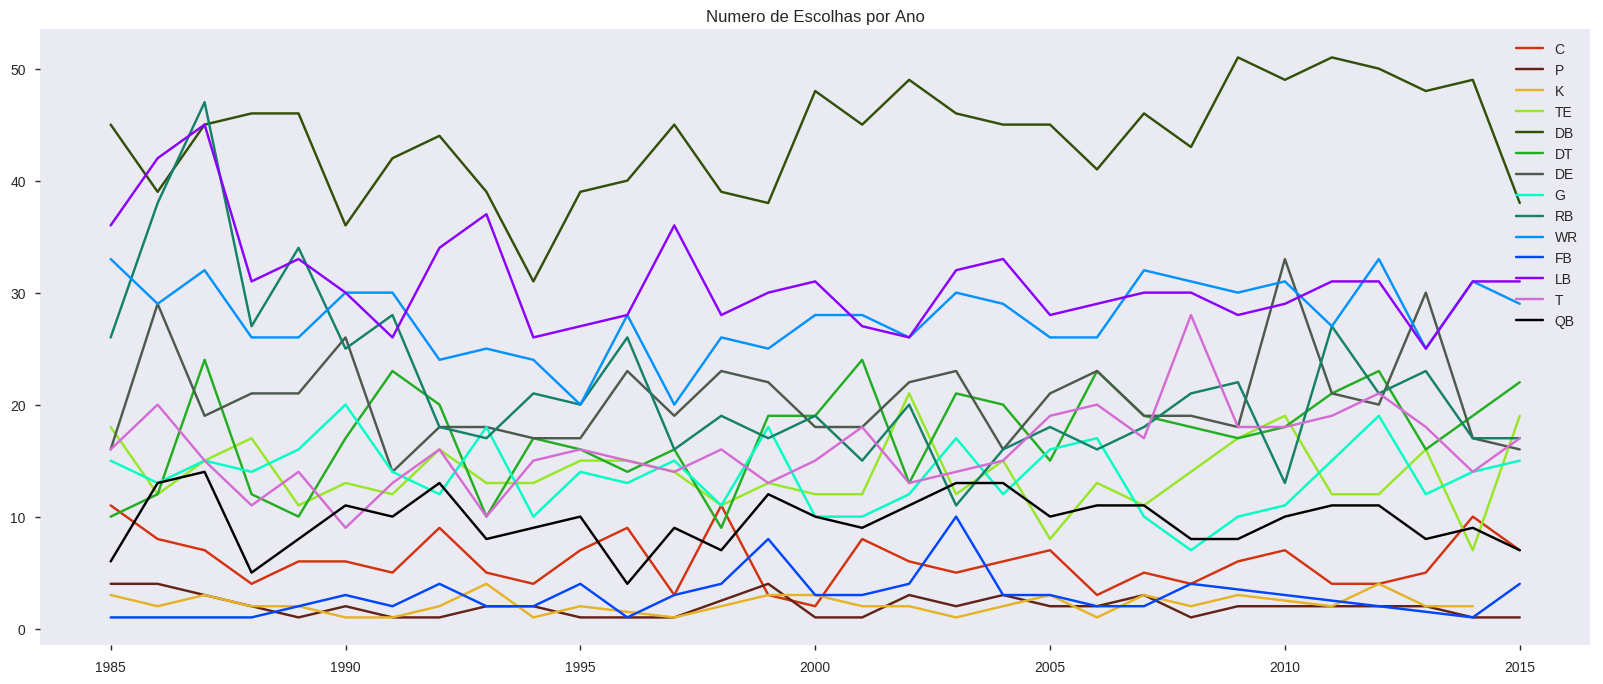

In [19]:
DICT_COLORS = {
    "C": '#D33311',
    "P": '#632417',
    "K": '#E6B228',
    "TE": '#98E628',
    "DB": '#335009',
    "DT": '#21AE21',
    "DE": '#4C5B4C',
    "G": '#00FFC5',
    "RB": '#148269',
    "WR": '#0093FF',
    "FB": '#0046FF',
    "LB": '#8B00FF',
    "T": '#D56CD4',
    "QB": '#000000',
    
}

positions = list(set(df_draft['Position Standard']))
df_positions = {}
info = list()
for pos in positions:
    df_positions[pos] = df_draft[df_draft['Position Standard'] == pos]
    
plt.figure(figsize=(20,8))
title = "Numero de Escolhas por Ano"
plt.title(title)
plt.grid(axis="both")

for pos in positions:
    plt.plot(df_positions[pos].groupby('Year').count()['Pick'], color=DICT_COLORS[pos])
    plt.legend(positions)

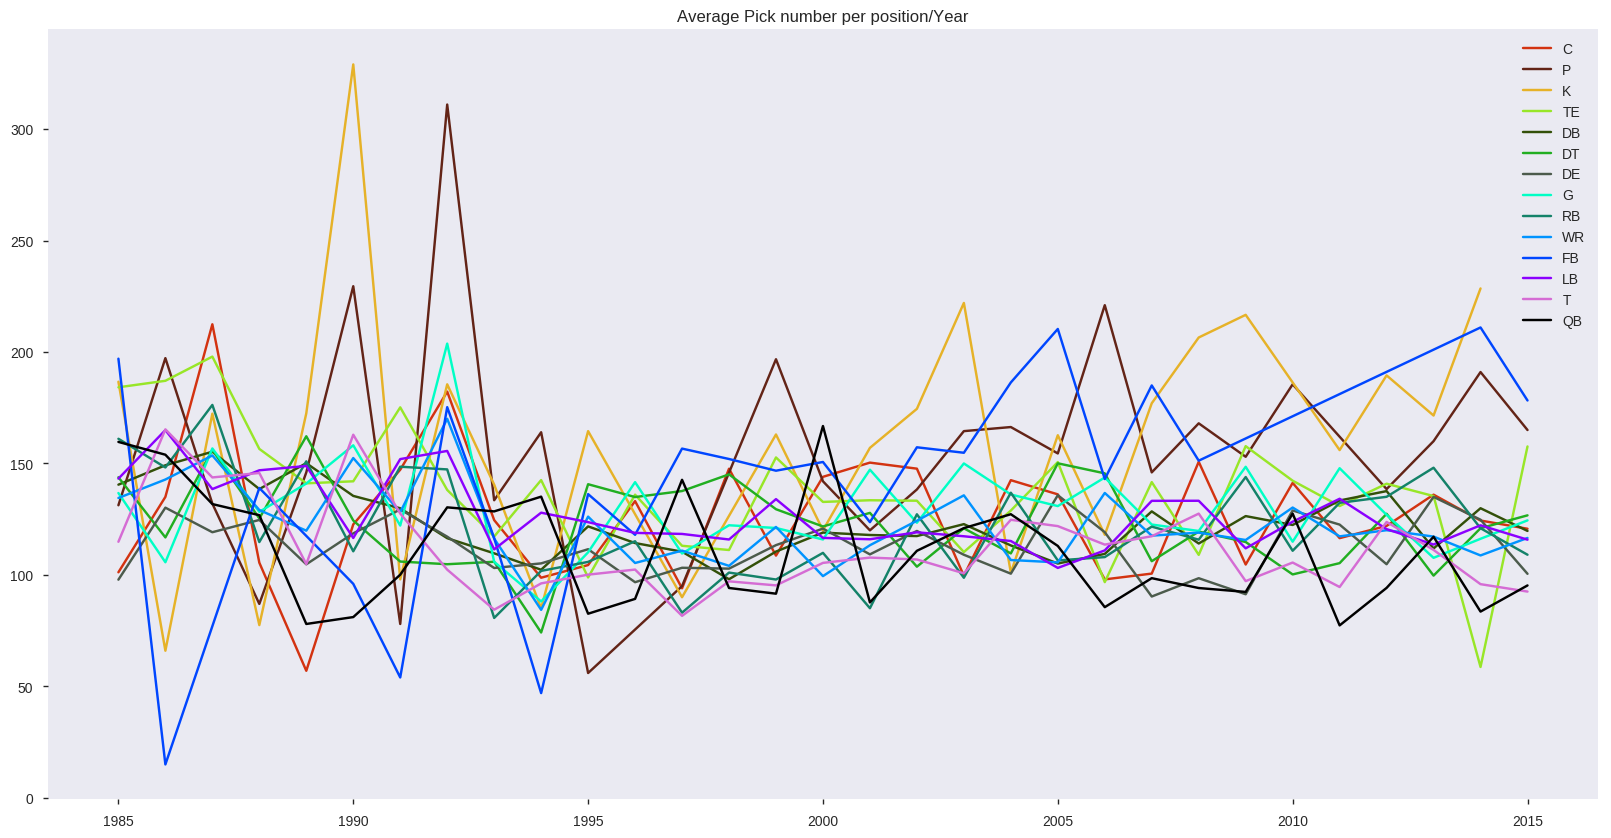

In [20]:
plt.figure(figsize=(20,10))
title = "Average Pick number per position/Year"
plt.title(title)
plt.grid(axis="both")
for pos in positions:
    plt.plot(df_positions[pos].groupby('Year').mean()['Pick'],color=DICT_COLORS[pos])
    plt.legend(positions)

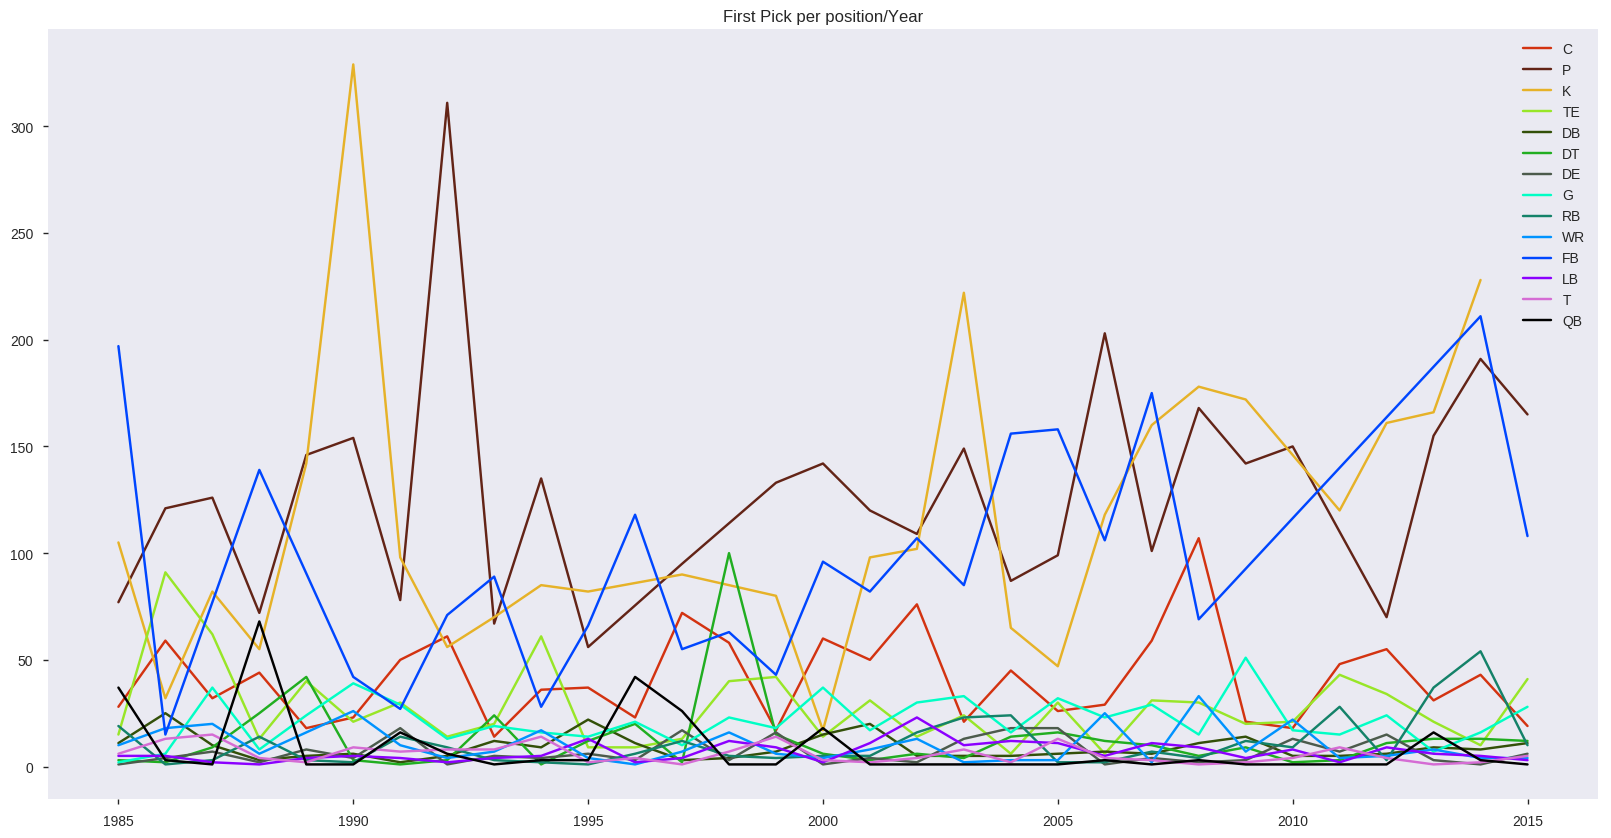

In [21]:
plt.figure(figsize=(20,10))
title = "First Pick per position/Year"
plt.title(title)
plt.grid(axis="both")
for pos in positions:
    plt.plot(df_positions[pos].groupby('Year').min()['Pick'],color=DICT_COLORS[pos])
    plt.legend(positions)

Apesar da posição Defensive Back ter um numero maior de escolhas por ano, fica claro que Tackle e Defensive End, Defensive Tackle e Quarterback são as posições vistas como impactantes. Sempre disputando as primeiras escolhas do draft o que indica uma valorisação maior dessas possições, principalmente no início dos anos 2000 quando jogadores dessas posições se tornam cada vez mais relevantes para os sucessos dos times nas ligas..

Text(0.5, 1.0, 'Total Number of Quarterback picks/Year')

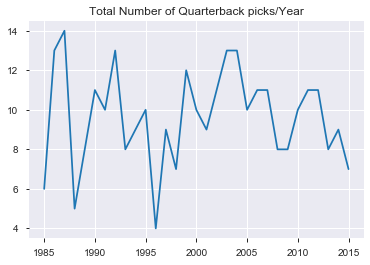

In [10]:
plt.plot(df_positions['QB'].groupby('Year').count()['Pick'])
plt.title("Total Number of Quarterback picks/Year")

Text(0.5, 1.0, 'Average Quarterback Pick number/Year')

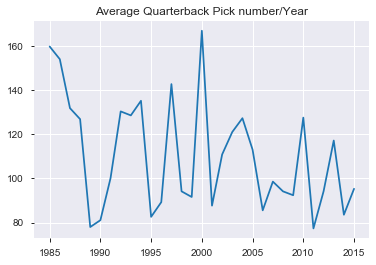

In [11]:
plt.plot(df_positions['QB'].groupby('Year').mean()['Pick'])
plt.title("Average Quarterback Pick number/Year")

Text(0.5, 1.0, 'Total Number of Running Backs picks/Year')

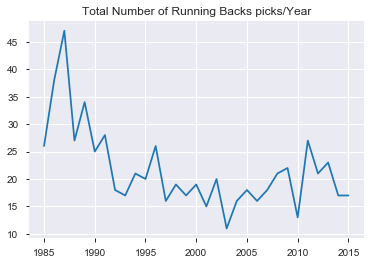

In [12]:
plt.plot(df_positions['RB'].groupby('Year').count()['Pick'])
plt.title("Total Number of Running Backs picks/Year")

Text(0.5, 1.0, 'Average Running Back Pick number/Year')

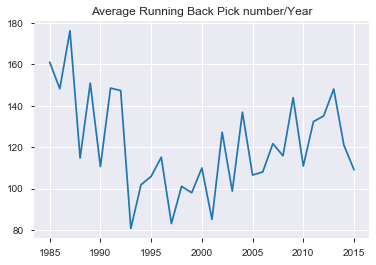

In [13]:
plt.plot(df_positions['RB'].groupby('Year').mean()['Pick'])
plt.title("Average Running Back Pick number/Year")

Text(0.5, 1.0, 'Total Number of Wide Receivers picks/Year')

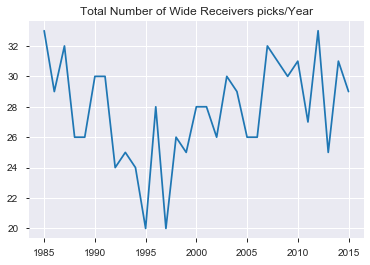

In [14]:
plt.plot(df_positions['WR'].groupby('Year').count()['Pick'])
plt.title("Total Number of Wide Receivers picks/Year")

Text(0.5, 1.0, 'Average Wide Receiver Pick number/Year')

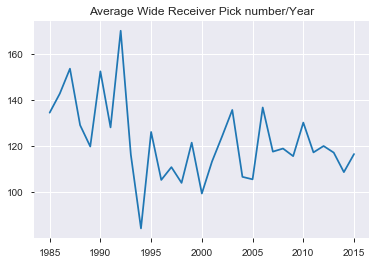

In [15]:
plt.plot(df_positions['WR'].groupby('Year').mean()['Pick'])
plt.title("Average Wide Receiver Pick number/Year")

Logo em seguida podemos ver quais posições tem sido mais "oferecidas" pelas universidades americanas ao longo do tempo como por exemplo, Nebraska tendo 32 Defensive Backs draftados desde os anos 80 e Florida State com 25 Linebackers draftados no período.

In [17]:
#Total de posições que cada College/Univ "ofereceu" ao draft
College_Position = df_draft.groupby(['Position_Standard','College/Univ']).count()['Player_Id']

#Para cada posição, imprime o College/Univ. com mais atletas draftados da posição e a quantidade
for pos in positions:
    max_val = College_Position[pos].max() 
    top_pos = College_Position[pos].index[list(College_Position[pos]).index(max_val)]
    print("Position: " + pos + " -- " + "Top College: " + top_pos + ' -- ' + "Athlets: " + str(max_val))

Position: RB -- Top College: Miami (FL) -- Athlets: 16
Position: LB -- Top College: Penn St. -- Athlets: 25
Position: DE -- Top College: Florida St. -- Athlets: 14
Position: C -- Top College: Notre Dame -- Athlets: 8
Position: LS -- Top College: Navy -- Athlets: 1
Position: FB -- Top College: Auburn -- Athlets: 4
Position: K -- Top College: Georgia -- Athlets: 4
Position: QB -- Top College: Oregon -- Athlets: 9
Position: TE -- Top College: Notre Dame -- Athlets: 13
Position: G -- Top College: Penn St. -- Athlets: 13
Position: T -- Top College: Texas A&M -- Athlets: 12
Position: P -- Top College: Michigan St. -- Athlets: 4
Position: WR -- Top College: Florida St. -- Athlets: 22
Position: DB -- Top College: Nebraska -- Athlets: 32
Position: DT -- Top College: Florida St. -- Athlets: 17


Aqui temos, os melhores drafts de cada time e em qual ano isso aconteceu, isso é medido pelo impacto dos jogadores draftados pelo times em seus primeiros anos de carreira onde é período com a maior probabilidade de o jogador ser útil para o seu time, principalmente por motivos de contratos que podem ser renovados, ou não.

In [19]:
#Draft AV por time a cada ano
DrAV_Team_Year = df_draft.groupby(['Tm','Year']).sum()['DrAV']

teams = set(df_draft['Tm'])
for team in teams:
    #print -- Time -- Best Year -- Year
    top_val = DrAV_Team_Year[team].max()
    top_year = DrAV_Team_Year[team].index[list(DrAV_Team_Year[team]).index(top_val)]
    print("Team: " + team + ' -- ' + "Best Draft: " + str(top_year) + ' -- ' + "DrAV: " + str(top_val))

Team: RAM -- Best Draft: 1994 -- DrAV: 170.0
Team: HOU -- Best Draft: 1995 -- DrAV: 182.0
Team: NOR -- Best Draft: 2006 -- DrAV: 286.0
Team: PHO -- Best Draft: 1991 -- DrAV: 135.0
Team: CIN -- Best Draft: 2001 -- DrAV: 210.0
Team: CHI -- Best Draft: 2003 -- DrAV: 235.0
Team: PIT -- Best Draft: 1987 -- DrAV: 292.0
Team: NWE -- Best Draft: 1993 -- DrAV: 244.0
Team: KAN -- Best Draft: 2008 -- DrAV: 189.0
Team: WAS -- Best Draft: 1986 -- DrAV: 133.0
Team: DEN -- Best Draft: 2006 -- DrAV: 148.0
Team: SFO -- Best Draft: 1986 -- DrAV: 345.0
Team: NYJ -- Best Draft: 2000 -- DrAV: 213.0
Team: GNB -- Best Draft: 2000 -- DrAV: 232.0
Team: TEN -- Best Draft: 2005 -- DrAV: 187.0
Team: MIN -- Best Draft: 1988 -- DrAV: 179.0
Team: PHI -- Best Draft: 1986 -- DrAV: 244.0
Team: DET -- Best Draft: 1989 -- DrAV: 197.0
Team: ATL -- Best Draft: 2008 -- DrAV: 248.0
Team: SDG -- Best Draft: 2004 -- DrAV: 212.0
Team: DAL -- Best Draft: 2005 -- DrAV: 241.0
Team: CAR -- Best Draft: 2001 -- DrAV: 187.0
Team: MIA 

Por fim separamos os jogadores em intervalos de carreira de 5 em 5 anos, ate os 20 anos. Calculamos a média da diferença da avaliação desse jogador entre sua carreira inteira e seus primeiros 4 anos (primeiro contrato), feito para cada posição. Assim podemos ter uma noção de como os primeiros 4 anos de carreira de um jogador são discriminativos para cada posição e para cada tempo de carreira, podendo analisar se jogadores de algumas posições tendem a atingir seu auge de carreira após os 10-15 anos ou tem esse auge no incio da carreira.

Podemos ver tambem como o numero de atletas diminiu consideravelmente ao longo do tempo de carreira, principalmente em posições mais fisicamente exigentes, como **Defensive Backs**, **Defensive Ends**, **Linebackers** e jogadores de linha ofensiva (**Guards**, **Tackles** e **Centers**).

In [22]:
#Divisão do dataset em anos de carreira
Carrer_years = {}
Carrer_years['0-5'] = df_draft[df_draft['carrer_years'] <= 5]
Carrer_years['6-10'] = df_draft[(df_draft['carrer_years'] >5)  & (df_draft['carrer_years'] <= 10)]
Carrer_years['11-15'] = df_draft[(df_draft['carrer_years'] > 10) & (df_draft['carrer_years'] <= 15)]
Carrer_years['16-20'] = df_draft[df_draft['carrer_years'] > 15]

#Para cada posição tem-se para cada intervalo de 5 anos de carreira como o AV da carreira do jogador é representado pelo AV dos seus primeiros 4 anos.
#Assim pode-se medir como jogadores de certas posições melhoram com o tempo e o quanto que esses evoluem.
for pos in positions:
    zero_five_diff_pos = (Carrer_years['0-5'][Carrer_years['0-5']['Pos'] == pos]['CarAV'] - Carrer_years['0-5'][Carrer_years['0-5']['Pos'] == pos]['First4AV']).mean()
    five_ten_diff_pos = (Carrer_years['6-10'][Carrer_years['6-10']['Pos'] == pos]['CarAV'] - Carrer_years['6-10'][Carrer_years['6-10']['Pos'] == pos]['First4AV']).mean()
    ten_fifteen_diff_pos = (Carrer_years['11-15'][Carrer_years['11-15']['Pos'] == pos]['CarAV'] - Carrer_years['11-15'][Carrer_years['11-15']['Pos'] == pos]['First4AV']).mean()
    fifteen_twenty_diff_pos = (Carrer_years['16-20'][Carrer_years['16-20']['Pos'] == pos]['CarAV'] - Carrer_years['16-20'][Carrer_years['16-20']['Pos'] == pos]['First4AV']).mean()
    print('00-05 Carrer Years -- ' + pos +  ' -- CarAV and First4AV difference (media): ' + str(round(zero_five_diff_pos,2)) + ' -- ' + "Atletas: " + str(len(Carrer_years['0-5'][Carrer_years['0-5']['Pos'] == pos]['CarAV'])))
    print('06-10 Carrer Years -- ' + pos +  ' -- CarAV and First4AV difference (media): ' + str(round(five_ten_diff_pos,2)) + ' -- ' + "Atletas: " + str(len(Carrer_years['6-10'][Carrer_years['6-10']['Pos'] == pos]['CarAV'])))
    print('11-15 Carrer Years -- ' + pos +  ' -- CarAV and First4AV difference (media): ' + str(round(ten_fifteen_diff_pos,2)) + ' -- ' + "Atletas: " + str(len(Carrer_years['11-15'][Carrer_years['11-15']['Pos'] == pos]['CarAV'])))
    print('16-20 Carrer Years -- ' + pos +  ' -- CarAV and First4AV difference (media): ' + str(round(fifteen_twenty_diff_pos,2)) + ' -- ' + "Atletas: " + str(len(Carrer_years['16-20'][Carrer_years['16-20']['Pos'] == pos]['CarAV'])))
    print('\n')

00-05 Carrer Years -- C -- CarAV and First4AV difference (media): -0.12 -- Atletas: 76
06-10 Carrer Years -- C -- CarAV and First4AV difference (media): 7.78 -- Atletas: 73
11-15 Carrer Years -- C -- CarAV and First4AV difference (media): 29.03 -- Atletas: 30
16-20 Carrer Years -- C -- CarAV and First4AV difference (media): 59.33 -- Atletas: 3


00-05 Carrer Years -- P -- CarAV and First4AV difference (media): 0.0 -- Atletas: 27
06-10 Carrer Years -- P -- CarAV and First4AV difference (media): 3.09 -- Atletas: 11
11-15 Carrer Years -- P -- CarAV and First4AV difference (media): 10.58 -- Atletas: 12
16-20 Carrer Years -- P -- CarAV and First4AV difference (media): 18.83 -- Atletas: 6


00-05 Carrer Years -- K -- CarAV and First4AV difference (media): -0.04 -- Atletas: 26
06-10 Carrer Years -- K -- CarAV and First4AV difference (media): 3.64 -- Atletas: 14
11-15 Carrer Years -- K -- CarAV and First4AV difference (media): 13.57 -- Atletas: 14
16-20 Carrer Years -- K -- CarAV and First4AV 